In [1]:
import numpy as np
from wremnants.datasets.datagroups import datagroups2016
from wremnants import plot_tools
from wremnants import histselections as sel
import copy

Welcome to JupyROOT 6.27/01


In [2]:
%load_ext autoreload
%autoreload 2

Convenience class to load the script boost output into a dictionary

In [22]:
groups = datagroups2016("../mw_with_mu_eta_pt.pkl.lz4")

In [129]:
groups.results["WplusmunuPostVFP"]["output"]["nominal"]

Hist(
  Regular(48, -2.4, 2.4, name='eta', label='eta'),
  Regular(29, 26, 55, name='pt', label='pt'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='charge', label='charge'),
  Boolean(name='passIso', label='passIso'),
  Boolean(name='passMT', label='passMT'),
  storage=Weight()) # Sum: WeightedSum(value=1.07113e+08, variance=1.35799e+08) (WeightedSum(value=1.23504e+08, variance=1.55218e+08) with flow)

In [23]:
histInfo = groups.datagroupsForHist("nominal", syst="", selectSignal=True, label="nominal")
histInfo = groups.datagroupsForHist("nominal", syst="uncorr", selectSignal=True)
prednames = [x for x in histInfo.keys() if x not in ["Data", "Wmunu_uncorr"]]

In [132]:
histInfo.keys()

dict_keys(['Data', 'Zmumu', 'Ztt', 'Fake', 'Wtau', 'Wmunu', 'Top', 'Diboson'])

In [9]:
histInfo["Wmunu_uncorr"] = copy.copy(histInfo["Wmunu"])
histInfo["Wmunu_uncorr"]["label"] = r"W$^{\pm}\to\mu\nu$ (no corr.)"
histInfo["Wmunu_uncorr"]["color"] = "red"
prednames_corr = [x for x in histInfo.keys() if x not in ["Data", "Wmunu"]]
histInfo["Wmunu_uncorr"]["nominal"] = sum([histInfo[x]["uncorr"] for x in prednames_corr])

In [28]:
histInfo = groups.addUncorrectedProc("nominal", "uncorr")

In [29]:
histInfo["uncorr"]

{'label': 'Uncorrected',
 'color': 'red',
 'members': [],
 'nominal': Hist(
   Regular(48, -2.4, 2.4, name='eta', label='eta'),
   Regular(29, 26, 55, name='pt', label='pt'),
   Regular(2, -2, 2, underflow=False, overflow=False, name='charge', label='charge'),
   storage=Weight()) # Sum: WeightedSum(value=1.08782e+08, variance=1.2346e+08) (WeightedSum(value=1.26534e+08, variance=6.22149e+08) with flow)}

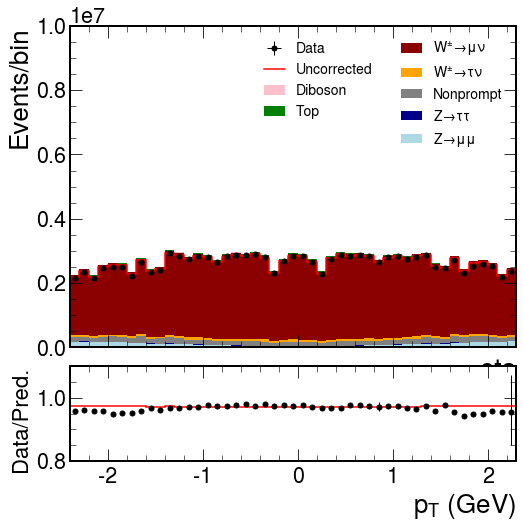

In [30]:
fig = plot_tools.makeStackPlotWithRatio(histInfo, prednames, action=lambda x: x.project("eta"), label="nominal", unstacked=["uncorr", "Data"], xlabel=r"p$_{T}$ (GeV)", scale=1e7, rrange=[0.8, 1.1])

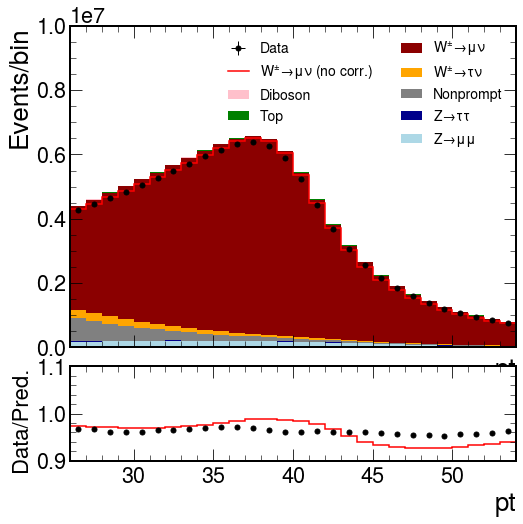

In [10]:
ptfig = plot_tools.makeStackPlotWithRatio(histInfo, prednames, label="nominal", scale=1e7, action=lambda x: x.project("pt"), unstacked=["Wmunu_uncorr", "Data"], xlabel="", ylabel="Events/bin", rrange=[0.9, 1.1])

In [3]:
groupsWlike = datagroups2016("../mz_wlike_with_mu_eta_pt.pkl.lz4", wlike=True)

In [4]:
histInfoWlike = groupsWlike.datagroupsForHist("nominal", syst="", selectSignal=True, label="nominal")
histInfoWlike = groupsWlike.datagroupsForHist("nominal", syst="uncorr", selectSignal=True)
prednamesWlike = [x for x in histInfoWlike.keys() if x not in ["Data",]]

In [32]:
histInfoWlike = groupsWlike.addUncorrectedProc("nominal", "uncorr", label="No N$^{3}$LL Corr.")

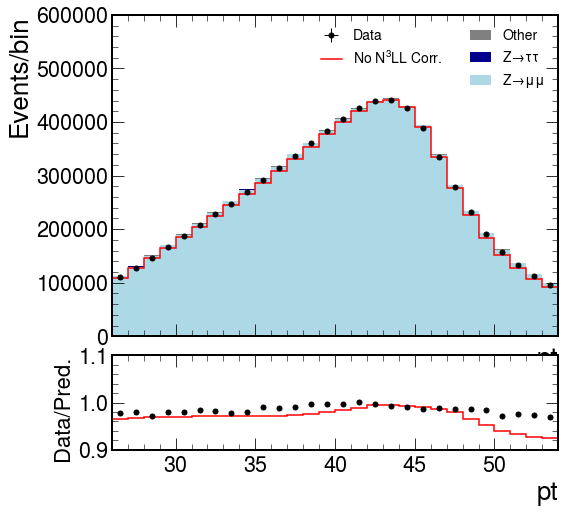

In [33]:
ptfig = plot_tools.makeStackPlotWithRatio(histInfoWlike, prednamesWlike, label="nominal", scale=6e5, action=lambda x: x.project("pt"), unstacked=["uncorr", "Data"], xlabel="", ylabel="Events/bin", rrange=[0.9, 1.1])


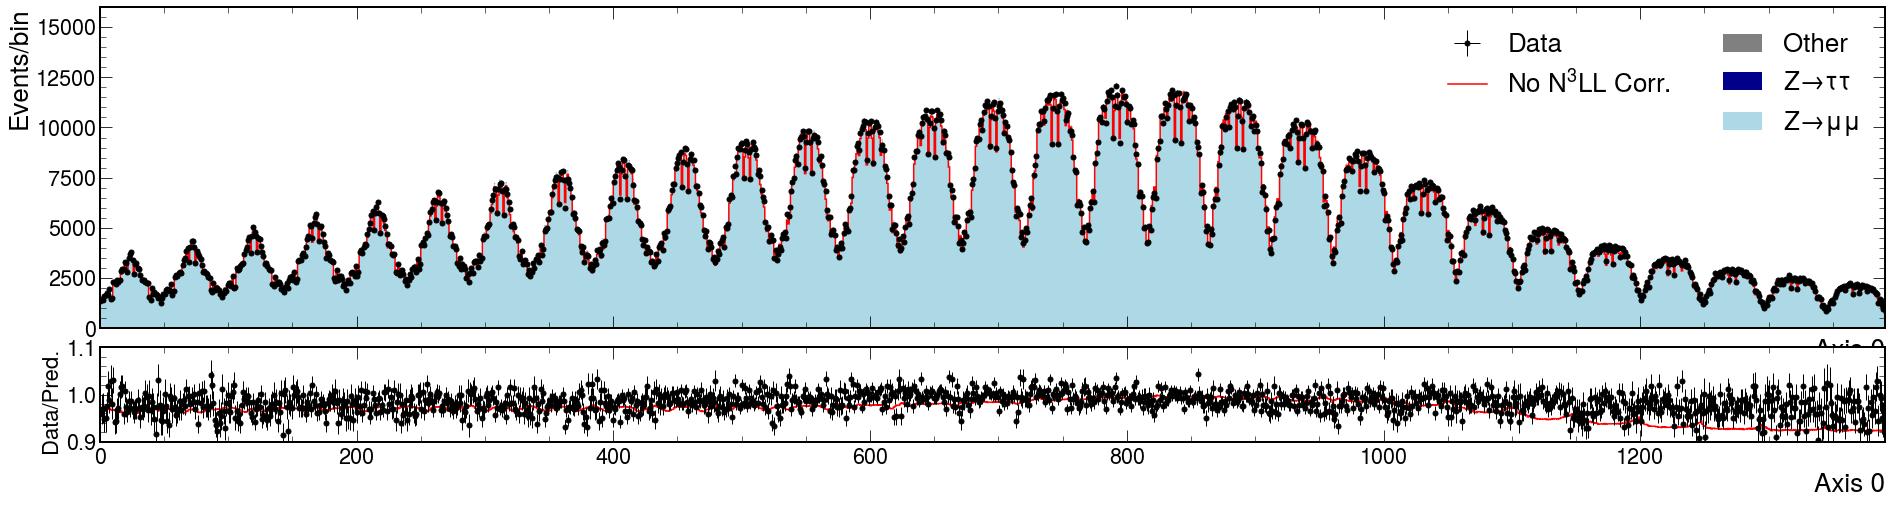

In [37]:
ptfig = plot_tools.makeStackPlotWithRatio(histInfoWlike, prednamesWlike, label="nominal", scale=1.6e4, action=sel.unrolledHist, unstacked=["uncorr", "Data"], xlabel="", ylabel="Events/bin", rrange=[0.9, 1.1])

In [60]:
histInfoWlike = groupsWlike.datagroupsForHist("dilepton", syst="", selectSignal=True)
histInfoWlike = groupsWlike.datagroupsForHist("dilepton", syst="uncorr", selectSignal=True)

In [61]:
histInfoWlike = groupsWlike.addUncorrectedProc("dilepton", "uncorr", label="No N$^{3}$LL Corr.")

/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


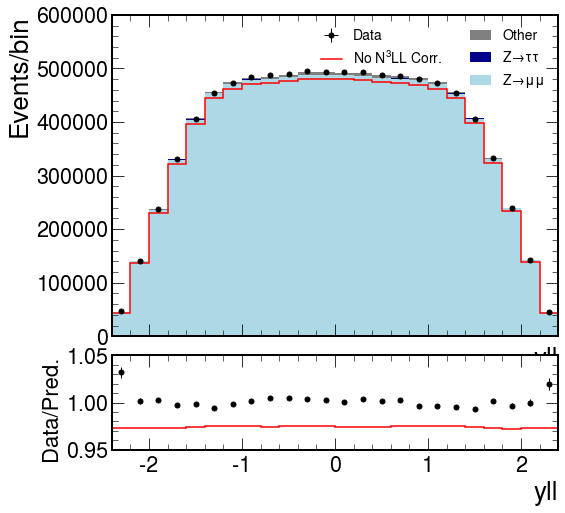

In [63]:
yfig = plot_tools.makeStackPlotWithRatio(histInfoWlike, prednamesWlike, label="dilepton", scale=6e5, action=lambda x: x.project("yll"), unstacked=["uncorr","Data"], xlabel="", ylabel="Events/bin", rrange=[0.95, 1.05], xlim=[-2.4,2.4])

